#INDOOR SCENES CLASSIFICATION PROJECT

## 📚 PHASE 1: SETUP & IMPORTS

 📦 CELL 1: Import All Libraries


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import files
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


## 📊 PHASE 2: DATA LOADING & EXPLORATION

📊 CELL 2: Define Helper Functions for Visualization

In [ ]:
def display_split_samples(image_list, label_list, n=5, title="Samples"):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        idx = random.randint(0, len(image_list)-1)
        img = Image.open(image_list[idx])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{id_to_label[label_list[idx]]} ({label_list[idx]})")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

def display_random_samples(root, transform=None, n_samples=9):
    image_paths = []
    labels = []

    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(path, name)
                label = os.path.basename(path)
                image_paths.append(full_path)
                labels.append(label)

    if len(image_paths) == 0:
        print("❌ No images found in", root)
        return
    samples = random.sample(list(zip(image_paths, labels)), min(n_samples, len(image_paths)))

    plt.figure(figsize=(12, 12))
    for i, (img_path, label) in enumerate(samples):
        img = Image.open(img_path)
        if transform:
            img = transform(img)

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(label, fontsize=12)
        plt.axis("off")
    plt.show()

def display_augmented_samples(root, transform, n_samples=9):
    image_paths = []
    labels = []

    for path, subdirs, files in os.walk(root):
        for name in files:
            if name.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(path, name)
                label = os.path.basename(path)
                image_paths.append(full_path)
                labels.append(label)

    samples = random.sample(list(zip(image_paths, labels)),
                            min(n_samples, len(image_paths)))

    plt.figure(figsize=(12, 12))

    for i, (img_path, label) in enumerate(samples):
        img = Image.open(img_path)

        img_tensor = transform(img)
        img_np = img_tensor.permute(1, 2, 0).numpy()

        plt.subplot(3, 3, i + 1)
        plt.imshow(img_np)
        plt.title(label + " (aug)")
        plt.axis("off")

    plt.show()

def display_labeled_samples_corrected(root_dir, transform, n=6):
    image_paths = []

    for class_name in os.listdir(root_dir):
        class_folder = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_folder):
            continue

        # ❗ Ignore classes not in selected 20
        if class_name not in label_to_id:
            continue

        for f in os.listdir(class_folder):
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append((os.path.join(class_folder, f), class_name))

    if len(image_paths) == 0:
        print("❌ No images found for selected labels!")
        return

    plt.figure(figsize=(14, 6))
    for i in range(n):
        path, label_name = random.choice(image_paths)
        img = Image.open(path)
        label_id = label_to_id[label_name]

        img_tensor = transform(img)
        img_np = img_tensor.permute(1, 2, 0).numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.title(f"{label_name} ({label_id})")
        plt.axis("off")
    plt.show()


🔑 CELL 3: Setup Kaggle & Download Dataset

In [ ]:
print("⚠️ Upload kaggle.json")
uploaded = files.upload()

if "kaggle.json" not in uploaded:
    raise Exception("❌ kaggle.json not found!")

os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("✅ Kaggle ready")

!kaggle datasets download -d itsahmad/indoor-scenes-cvpr-2019
!unzip indoor-scenes-cvpr-2019.zip -d indoor_scenes

⚠️ Upload kaggle.json


Streaming output truncated to the last 5000 lines.
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/solarstudio.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio14.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio16.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio2.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio21.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio87.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio99.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio_1.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio_2.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio_a.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio_overall.jpg  
  inflating: indoor_scenes/indoorCVPR_09/Images/studiomusic/studio_pic_for_website.jpg  
  inflating: indoor_scenes/

## 🔄 PHASE 3: DATA PREPROCESSING & AUGMENTATION

📂 CELL 4: Explore Dataset

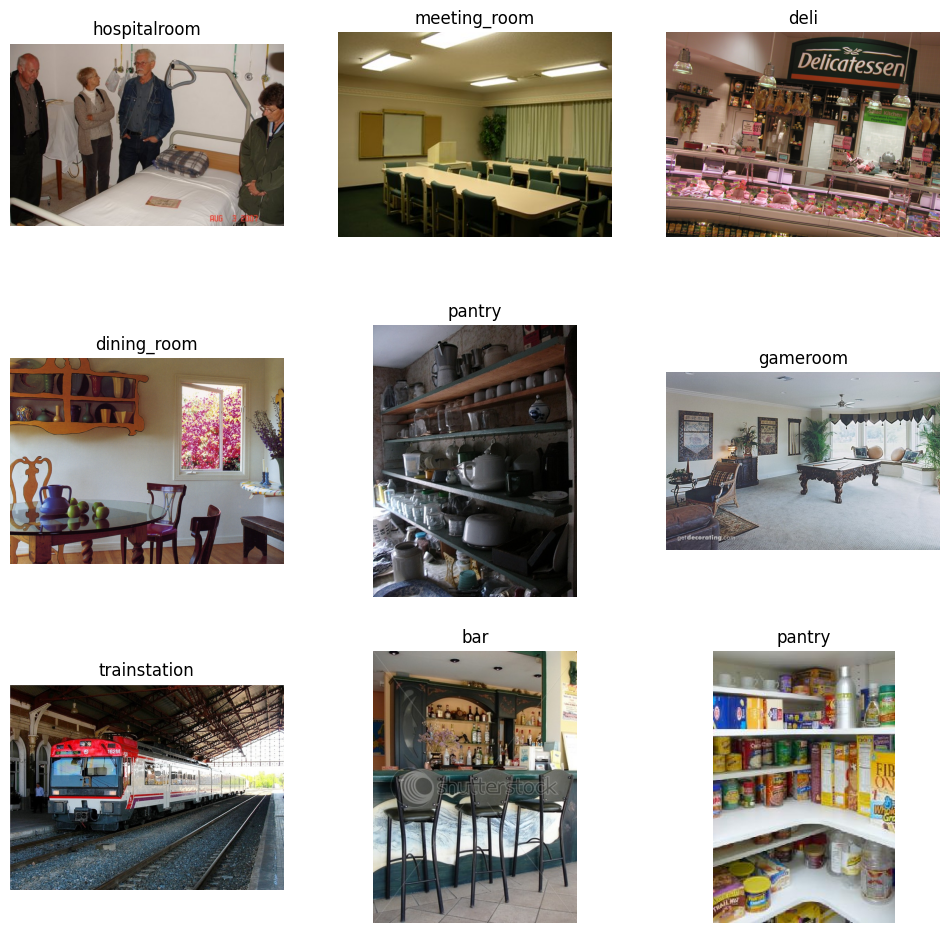

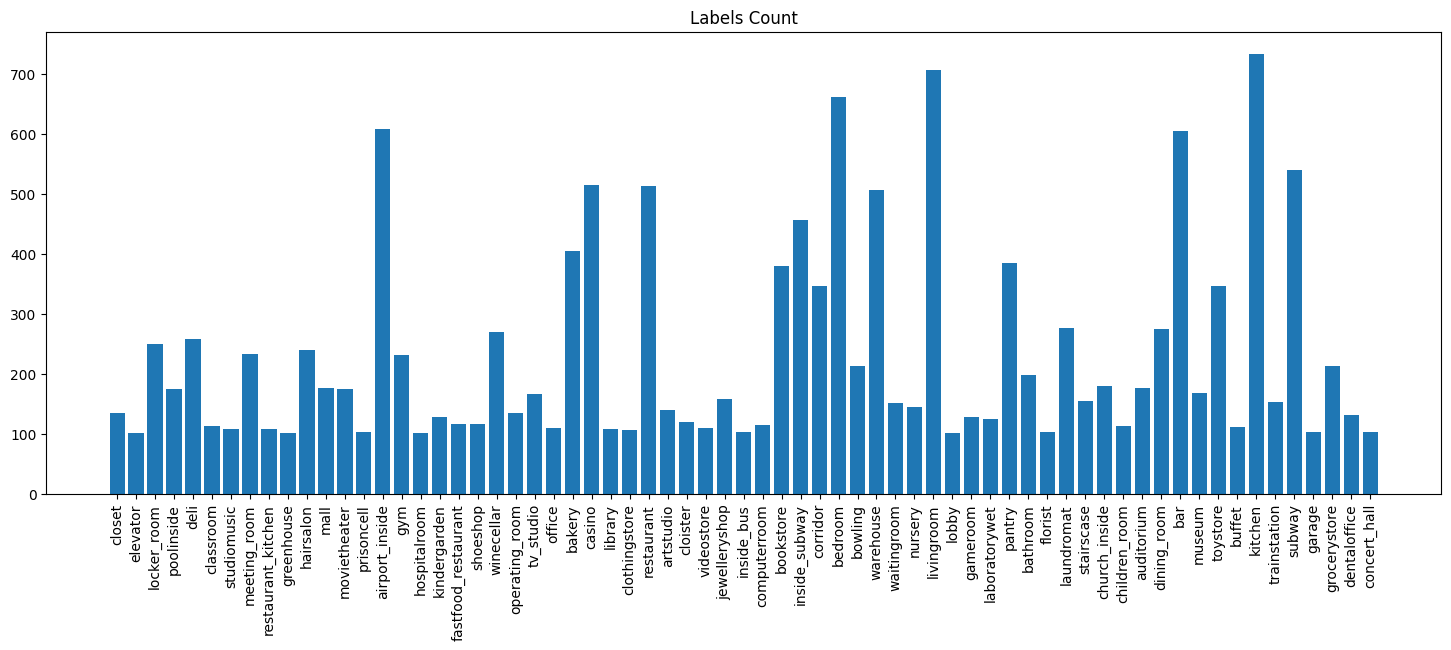

In [ ]:
root = "/content/indoor_scenes"
display_random_samples(root, n_samples=9)

labels = []
for path, subdirs, files in os.walk(root):
    for name in files:
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            labels.append(os.path.basename(path))

label_counts = Counter(labels)

plt.figure(figsize=(18,6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=90)
plt.title("Labels Count")
plt.show()


🖼️ CELL 5: Define Data Transforms

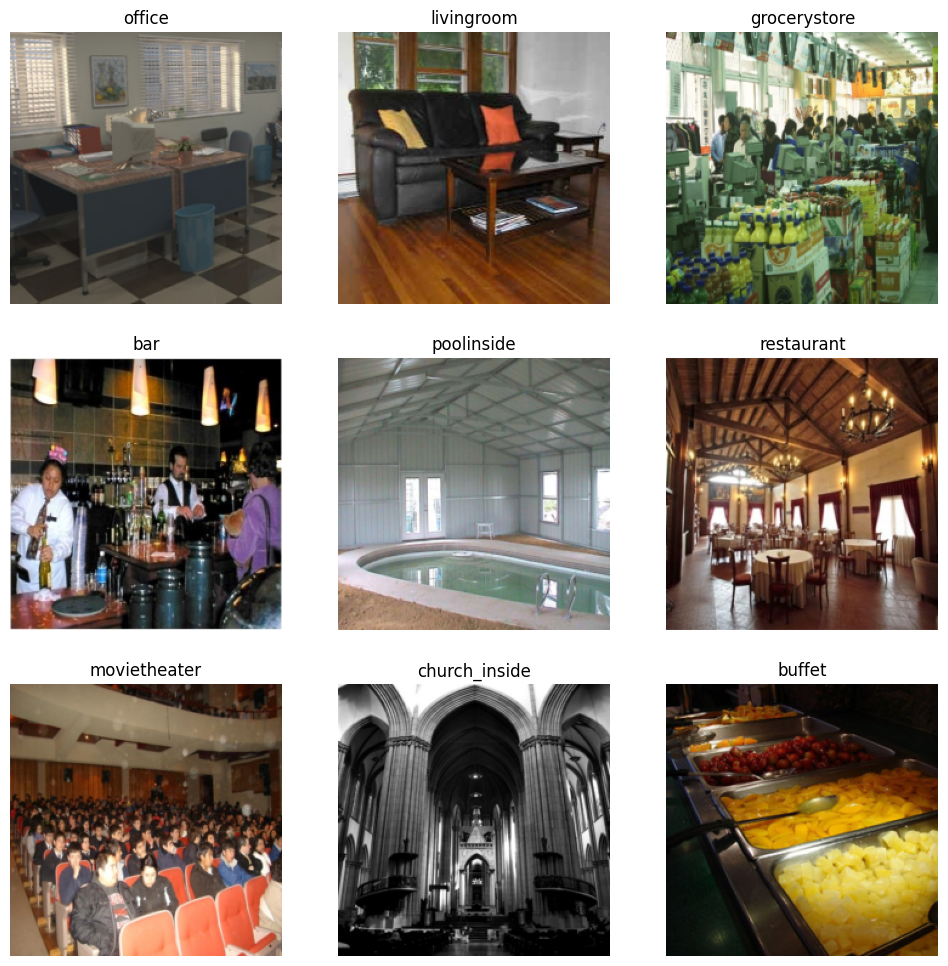

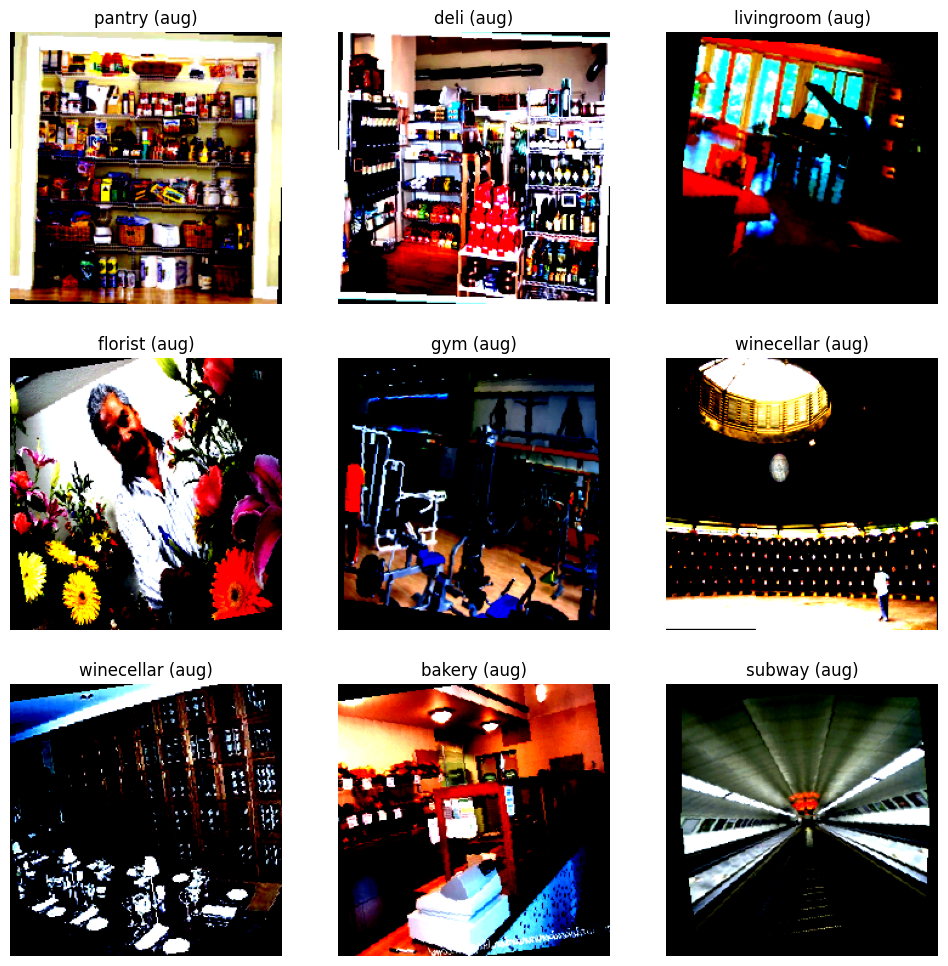

In [ ]:
transform_resize_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB"))
])
display_random_samples(root, transform=transform_resize_rgb)

transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
display_augmented_samples(root, transform_augmented)

🏷️ CELL 6: Select Classes & Create Label Mappings

Selected 20 classes:
['airport_inside', 'artstudio', 'auditorium', 'bakery', 'bar', 'bathroom', 'bedroom', 'bookstore', 'bowling', 'buffet', 'casino', 'children_room', 'church_inside', 'classroom', 'cloister', 'closet', 'clothingstore', 'computerroom', 'concert_hall', 'corridor']


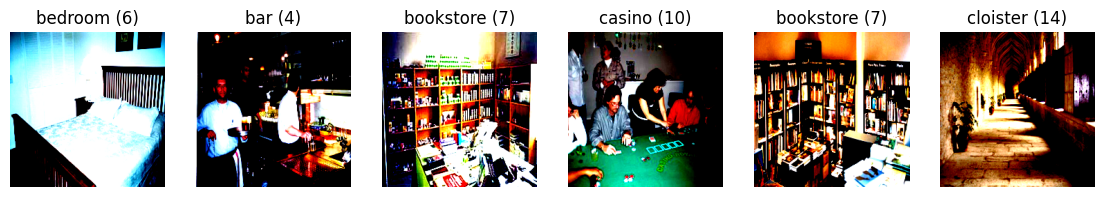

In [ ]:
root_dir = "/content/indoor_scenes/indoorCVPR_09/Images"

MAX_CLASSES = 20

all_classes = sorted([
    d for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d))
])

classes = all_classes[:MAX_CLASSES]   # 20 فقط

print("Selected 20 classes:")
print(classes)

label_to_id = {label: idx for idx, label in enumerate(classes)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

transform_normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

display_labeled_samples_corrected(root_dir, transform_normalize)

## ✂️ PHASE 4: DATASET SPLITTING & PREPARATION

📋 CELL 7: Prepare Image Paths & Labels

In [ ]:
image_paths = []
labels = []

for class_name in classes:
    class_folder = os.path.join(root_dir, class_name)

    for f in os.listdir(class_folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(class_folder, f))
            labels.append(label_to_id[class_name])

print("Total images after filtering:", len(image_paths))

Total images after filtering: 5340


✂️ CELL 8: Split Dataset (Train/Val/Test), Save Test Split to Folders and Visualize Split Samples

✔ Test split saved successfully in folders per class!
Path: /content/test_split
Train: 3738
Validation: 801
Test: 801


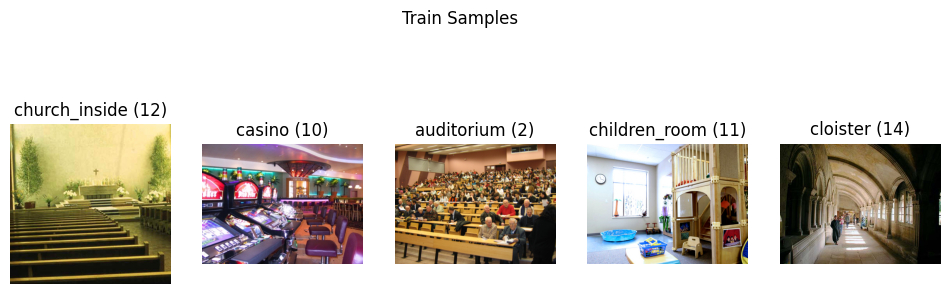

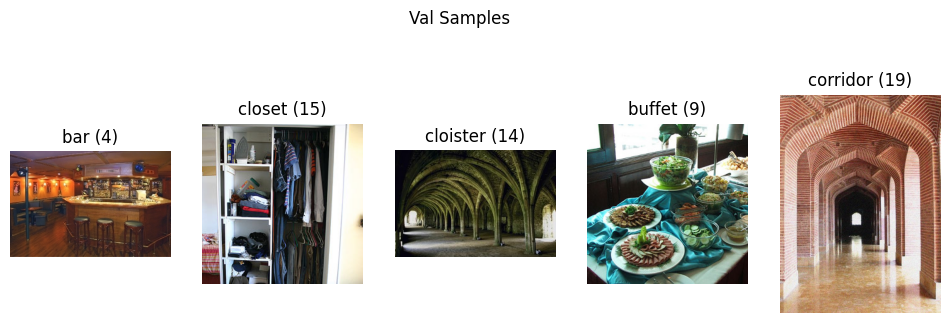

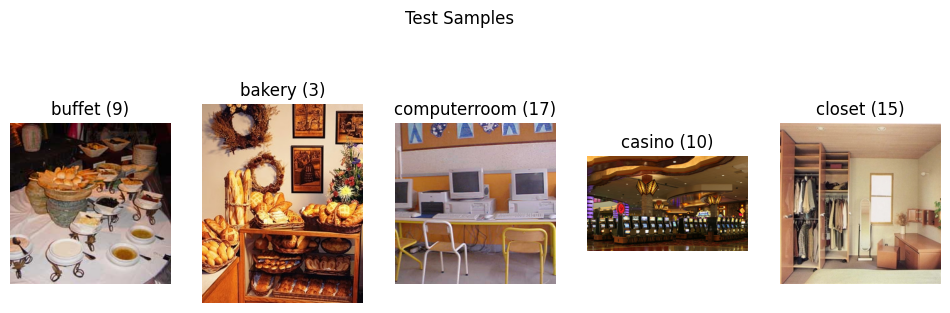

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


import os
import shutil

test_output_dir = "/content/test_split"
if os.path.exists(test_output_dir):
    shutil.rmtree(test_output_dir)

os.makedirs(test_output_dir)
for cls in classes:
    os.makedirs(os.path.join(test_output_dir, cls), exist_ok=True)

for img_path, label in zip(X_test, y_test):
    cls_name = id_to_label[label]
    filename = os.path.basename(img_path)
    dest_path = os.path.join(test_output_dir, cls_name, filename)

    shutil.copy(img_path, dest_path)

print("✔ Test split saved successfully in folders per class!")
print("Path:", test_output_dir)


print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))

display_split_samples(X_train, y_train, 5, "Train Samples")
display_split_samples(X_val, y_val, 5, "Val Samples")
display_split_samples(X_test, y_test, 5, "Test Samples")

🗂️ CELL 9: Create PyTorch Dataset Class and Create DataLoaders

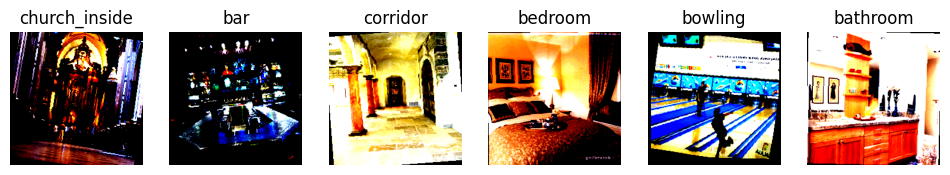

In [ ]:
class IndoorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = IndoorDataset(X_train, y_train, transform_augmented)
val_dataset   = IndoorDataset(X_val, y_val, transform_normalize)
test_dataset  = IndoorDataset(X_test, y_test, transform_normalize)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def show_batch(loader, n=6):
    imgs, labels = next(iter(loader))
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(imgs[i].permute(1,2,0).numpy())
        plt.title(id_to_label[labels[i].item()])
        plt.axis("off")
    plt.show()

show_batch(train_loader)

## 🏗️ PHASE 5: MODEL BUILDING

🏗️ CELL 10: Build ResNet50 Model

In [ ]:
def build_resnet50(num_classes=20, pretrained=True, freeze_backbone=True):
    print("📥 Loading ResNet50...")
    model = models.resnet50(pretrained=pretrained)


    if freeze_backbone:
        print("❄️ Freezing backbone layers...")
        for name, param in model.named_parameters():
            if "fc" not in name:
                param.requires_grad = False


    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

model = build_resnet50(num_classes=len(classes), pretrained=True, freeze_backbone=True)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ ResNet50 Model built successfully")
print(f"📊 Total parameters: {total_params:,}")
print(f"🔥 Trainable parameters: {trainable_params:,}")
print(f"❄️ Frozen parameters: {total_params - trainable_params:,}")


Using device: cuda
📥 Loading ResNet50...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


❄️ Freezing backbone layers...

✅ ResNet50 Model built successfully
📊 Total parameters: 26,144,340
🔥 Trainable parameters: 2,636,308
❄️ Frozen parameters: 23,508,032


⚙️ CELL 11: Setup Loss, Optimizer & Scheduler

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"⚙️ Optimizer: Adam (lr=0.001)")
print(f"📉 Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"🎯 Loss Function: CrossEntropyLoss")

⚙️ Optimizer: Adam (lr=0.001)
📉 Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
🎯 Loss Function: CrossEntropyLoss


### 🔥 PHASE 6: MODEL TRAINING

🏃 CELL 12: Define Training Function

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{100.*correct/total:.2f}%"
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("✅ Training function defined")

✅ Training function defined


🔥 CELL 13: Training Loop

In [ ]:
NUM_EPOCHS = 25
PATIENCE = 7

best_val_acc = 0
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\n" + "="*50)
print("🚀 Starting Training with ResNet50")
print("="*50 + "\n")

for epoch in range(NUM_EPOCHS):
    print(f"📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print results
    print(f"✅ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"✅ Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, "best_resnet50_model.pth")
        print(f"💾 Best model saved! (Val Acc: {val_acc:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ No improvement ({patience_counter}/{PATIENCE})")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
        break

    # Update learning rate
    scheduler.step(val_loss)
    print()

print("="*50)
print(f"✅ Training Completed!")
print(f"🏆 Best Val Acc: {best_val_acc:.2f}%")
print(f"📉 Best Val Loss: {best_val_loss:.4f}")
print("="*50)



🚀 Starting Training with ResNet50

📅 Epoch 1/25
--------------------------------------------------


✅ Train Loss: 1.3596 | Train Acc: 59.60%
✅ Val Loss: 0.6997 | Val Acc: 76.90%
💾 Best model saved! (Val Acc: 76.90%)

📅 Epoch 2/25
--------------------------------------------------


✅ Train Loss: 0.9864 | Train Acc: 68.86%
✅ Val Loss: 0.6154 | Val Acc: 81.40%
💾 Best model saved! (Val Acc: 81.40%)

📅 Epoch 3/25
--------------------------------------------------


✅ Train Loss: 0.9034 | Train Acc: 70.76%
✅ Val Loss: 0.6508 | Val Acc: 80.40%
⏳ No improvement (1/7)

📅 Epoch 4/25
--------------------------------------------------


✅ Train Loss: 0.8720 | Train Acc: 72.10%
✅ Val Loss: 0.6034 | Val Acc: 80.52%
⏳ No improvement (2/7)

📅 Epoch 5/25
--------------------------------------------------


✅ Train Loss: 0.8633 | Train Acc: 71.56%
✅ Val Loss: 0.5459 | Val Acc: 82.77%
💾 Best model saved! (Val Acc: 82.77%)

📅 Epoch 6/25
--------------------------------------------------


✅ Train Loss: 0.8116 | Train Acc: 73.78%
✅ Val Loss: 0.5681 | Val Acc: 82.15%
⏳ No improvement (1/7)

📅 Epoch 7/25
--------------------------------------------------


✅ Train Loss: 0.8277 | Train Acc: 73.17%
✅ Val Loss: 0.5020 | Val Acc: 82.90%
💾 Best model saved! (Val Acc: 82.90%)

📅 Epoch 8/25
--------------------------------------------------


✅ Train Loss: 0.7714 | Train Acc: 74.99%
✅ Val Loss: 0.5794 | Val Acc: 80.90%
⏳ No improvement (1/7)

📅 Epoch 9/25
--------------------------------------------------


✅ Train Loss: 0.7724 | Train Acc: 74.69%
✅ Val Loss: 0.6052 | Val Acc: 82.15%
⏳ No improvement (2/7)

📅 Epoch 10/25
--------------------------------------------------


✅ Train Loss: 0.7773 | Train Acc: 75.17%
✅ Val Loss: 0.5231 | Val Acc: 82.40%
⏳ No improvement (3/7)

📅 Epoch 11/25
--------------------------------------------------


✅ Train Loss: 0.7455 | Train Acc: 75.76%
✅ Val Loss: 0.5230 | Val Acc: 82.65%
⏳ No improvement (4/7)

📅 Epoch 12/25
--------------------------------------------------


✅ Train Loss: 0.6743 | Train Acc: 77.98%
✅ Val Loss: 0.5094 | Val Acc: 83.65%
💾 Best model saved! (Val Acc: 83.65%)

📅 Epoch 13/25
--------------------------------------------------


✅ Train Loss: 0.6614 | Train Acc: 78.87%
✅ Val Loss: 0.4801 | Val Acc: 84.64%
💾 Best model saved! (Val Acc: 84.64%)

📅 Epoch 14/25
--------------------------------------------------


✅ Train Loss: 0.6768 | Train Acc: 77.80%
✅ Val Loss: 0.4762 | Val Acc: 84.02%
⏳ No improvement (1/7)

📅 Epoch 15/25
--------------------------------------------------


✅ Train Loss: 0.6481 | Train Acc: 78.54%
✅ Val Loss: 0.4822 | Val Acc: 84.39%
⏳ No improvement (2/7)

📅 Epoch 16/25
--------------------------------------------------


✅ Train Loss: 0.6318 | Train Acc: 78.76%
✅ Val Loss: 0.4966 | Val Acc: 83.77%
⏳ No improvement (3/7)

📅 Epoch 17/25
--------------------------------------------------


✅ Train Loss: 0.6428 | Train Acc: 78.46%
✅ Val Loss: 0.4580 | Val Acc: 85.39%
💾 Best model saved! (Val Acc: 85.39%)

📅 Epoch 18/25
--------------------------------------------------


✅ Train Loss: 0.6135 | Train Acc: 79.08%
✅ Val Loss: 0.4809 | Val Acc: 85.14%
⏳ No improvement (1/7)

📅 Epoch 19/25
--------------------------------------------------


✅ Train Loss: 0.6331 | Train Acc: 78.87%
✅ Val Loss: 0.4725 | Val Acc: 85.02%
⏳ No improvement (2/7)

📅 Epoch 20/25
--------------------------------------------------


✅ Train Loss: 0.6371 | Train Acc: 79.19%
✅ Val Loss: 0.4843 | Val Acc: 85.14%
⏳ No improvement (3/7)

📅 Epoch 21/25
--------------------------------------------------


✅ Train Loss: 0.6368 | Train Acc: 78.68%
✅ Val Loss: 0.5109 | Val Acc: 84.77%
⏳ No improvement (4/7)

📅 Epoch 22/25
--------------------------------------------------


✅ Train Loss: 0.5953 | Train Acc: 79.88%
✅ Val Loss: 0.4871 | Val Acc: 84.77%
⏳ No improvement (5/7)

📅 Epoch 23/25
--------------------------------------------------


✅ Train Loss: 0.5903 | Train Acc: 79.86%
✅ Val Loss: 0.4682 | Val Acc: 85.77%
💾 Best model saved! (Val Acc: 85.77%)

📅 Epoch 24/25
--------------------------------------------------


✅ Train Loss: 0.5906 | Train Acc: 80.63%
✅ Val Loss: 0.4579 | Val Acc: 86.02%
💾 Best model saved! (Val Acc: 86.02%)

📅 Epoch 25/25
--------------------------------------------------


✅ Train Loss: 0.5751 | Train Acc: 80.77%
✅ Val Loss: 0.4530 | Val Acc: 85.77%
⏳ No improvement (1/7)

✅ Training Completed!
🏆 Best Val Acc: 86.02%
📉 Best Val Loss: 0.4579


📈 CELL 14: Plot Training Curves

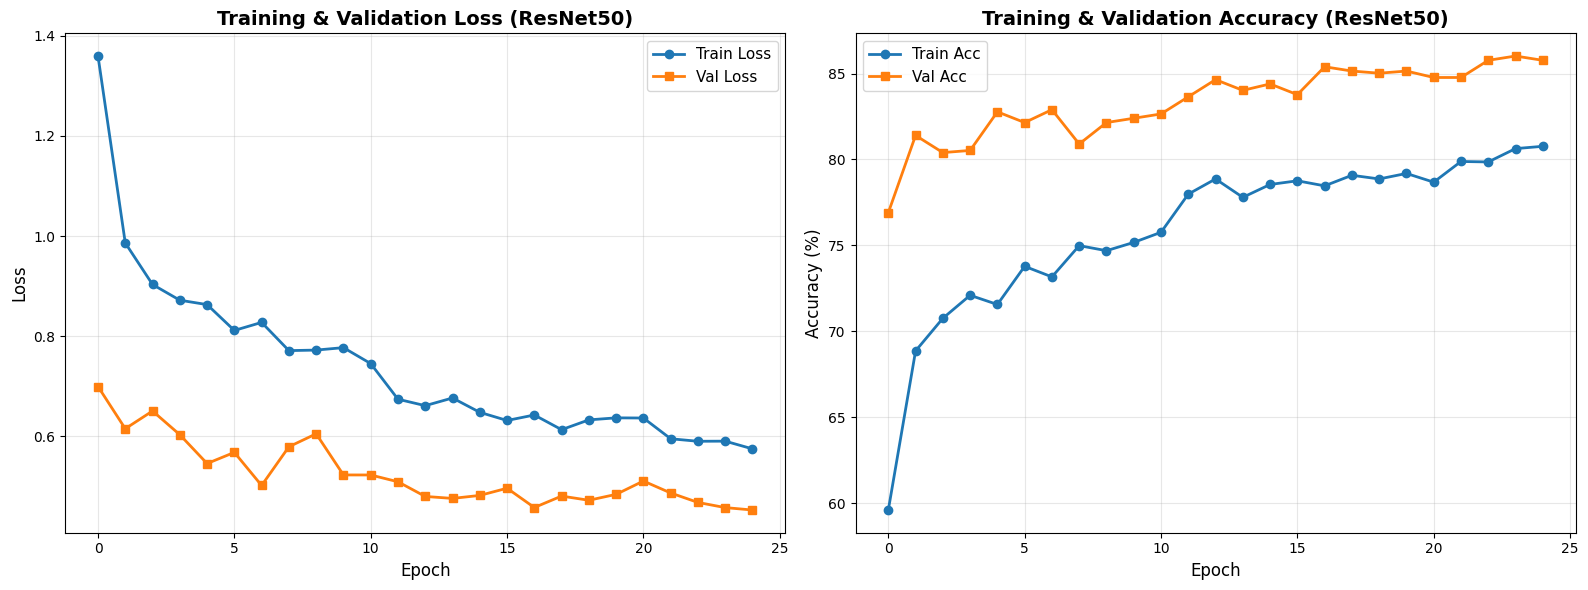

In [ ]:
plt.figure(figsize=(16, 6))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o', linewidth=2)
plt.plot(val_losses, label="Val Loss", marker='s', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training & Validation Loss (ResNet50)", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc", marker='o', linewidth=2)
plt.plot(val_accs, label="Val Acc", marker='s', linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Training & Validation Accuracy (ResNet50)", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📊 PHASE 7: MODEL EVALUATION & TESTING

✅ CELL 15: Define Validation Function

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

🎯 CELL 16: Load Best Model & Test

In [ ]:
print("\n📊 Evaluating on Test Set...")
print("-" * 50)

# Load best model
checkpoint = torch.load("best_resnet50_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")

# Test evaluation
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n🎯 Test Results:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.2f}%")
print("-" * 50)


📊 Evaluating on Test Set...
--------------------------------------------------
✅ Loaded best model from epoch 24



🎯 Test Results:
   Loss: 0.3960
   Test Accuracy: 87.02%
--------------------------------------------------


🔥 CELL 17: Confusion Matrix

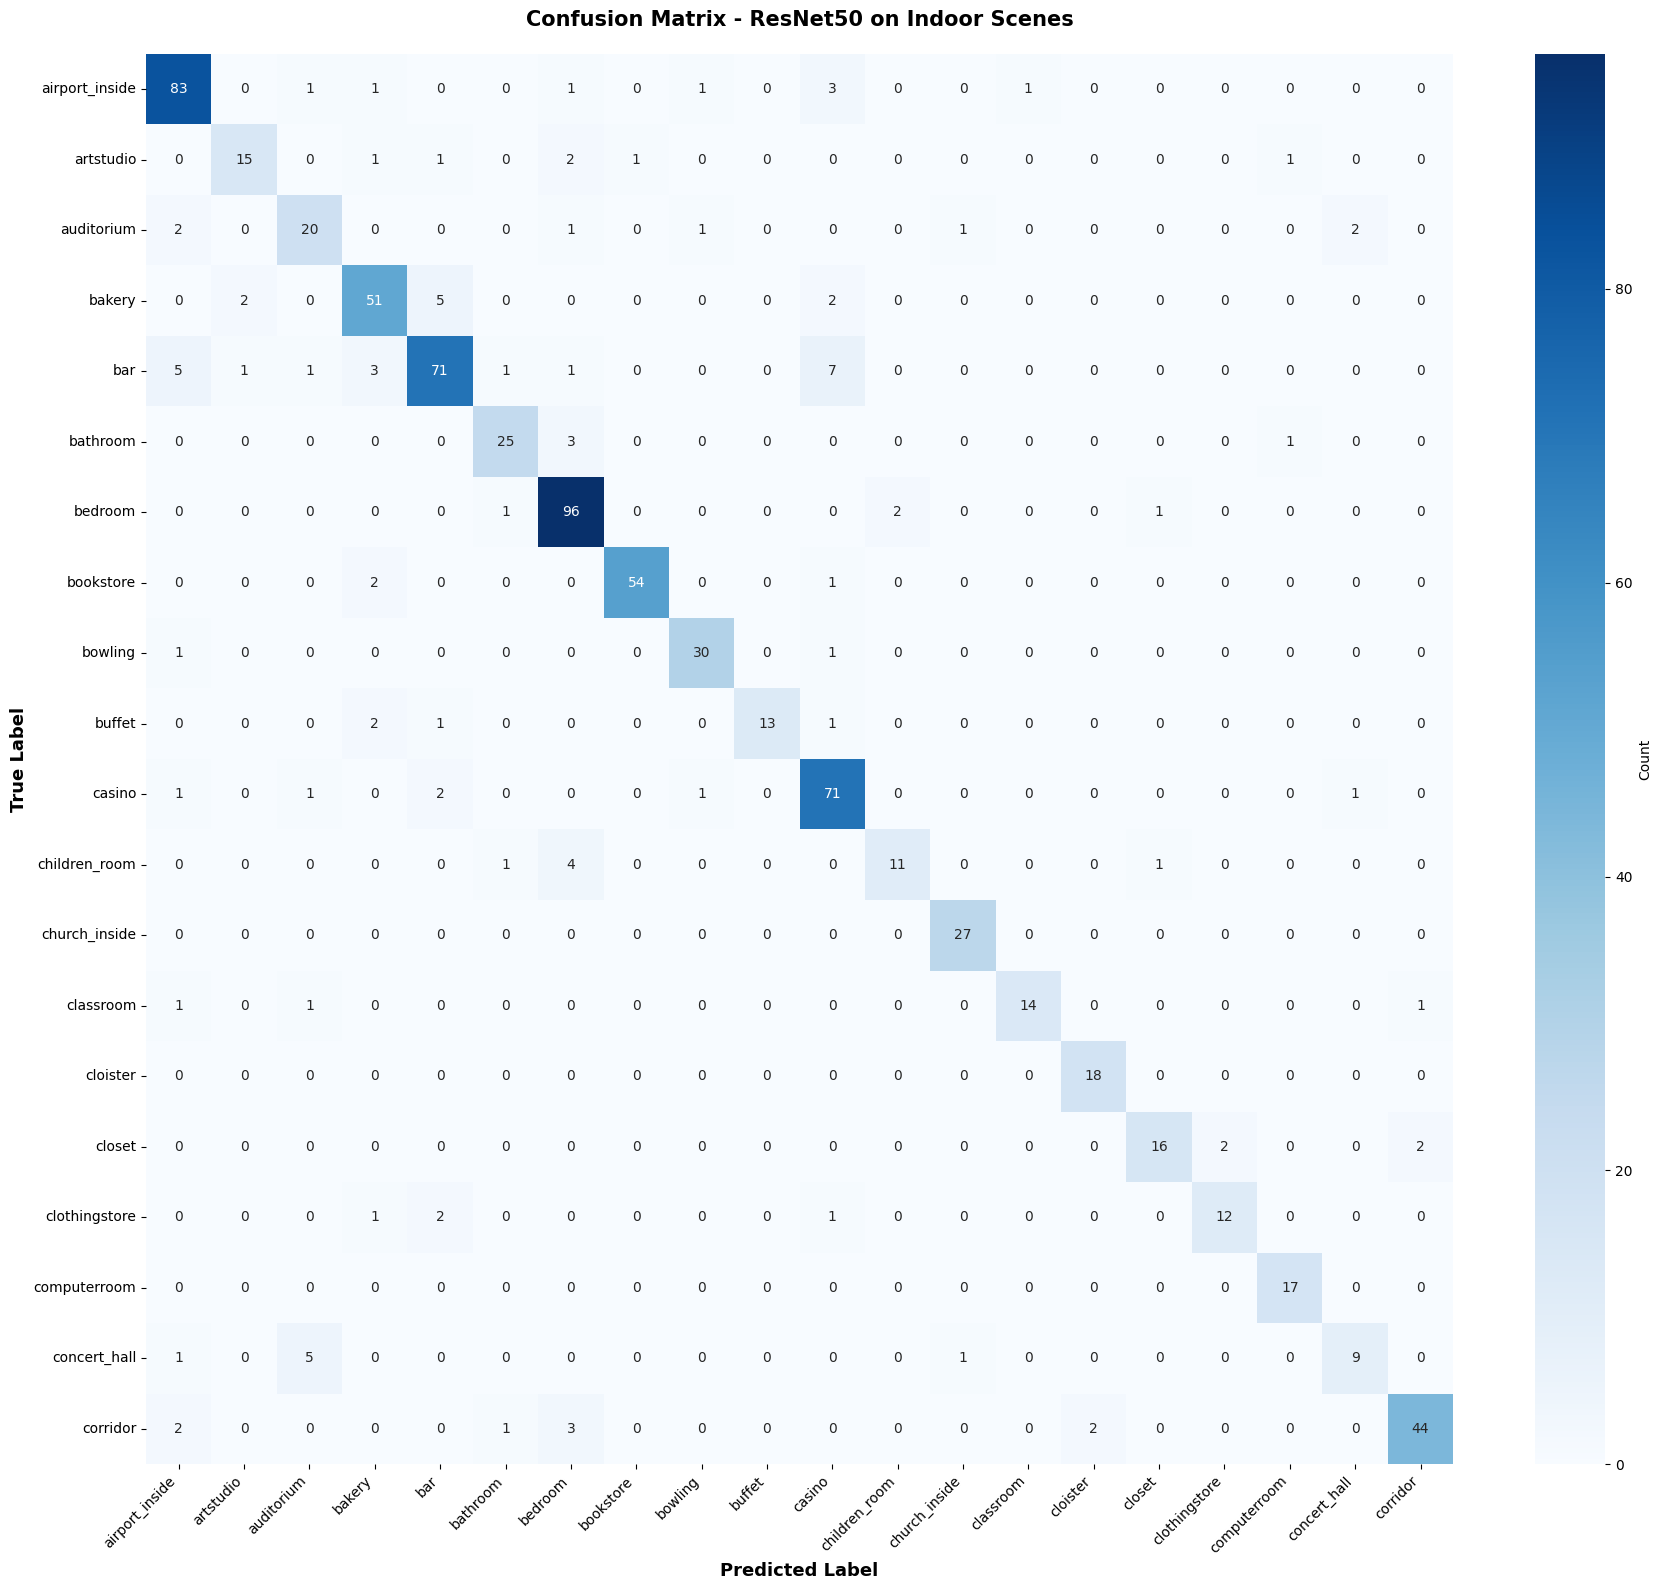

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted Label", fontsize=13, fontweight='bold')
plt.ylabel("True Label", fontsize=13, fontweight='bold')
plt.title("Confusion Matrix - ResNet50 on Indoor Scenes",
          fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📋 CELL 18: Classification Report

In [ ]:
print("\n📋 Detailed Classification Report:\n")
print("="*70)
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print(report)
print("="*70)


📋 Detailed Classification Report:

                precision    recall  f1-score   support

airport_inside      0.865     0.912     0.888        91
     artstudio      0.833     0.714     0.769        21
    auditorium      0.690     0.741     0.714        27
        bakery      0.836     0.850     0.843        60
           bar      0.866     0.789     0.826        90
      bathroom      0.862     0.862     0.862        29
       bedroom      0.865     0.960     0.910       100
     bookstore      0.982     0.947     0.964        57
       bowling      0.909     0.938     0.923        32
        buffet      1.000     0.765     0.867        17
        casino      0.816     0.922     0.866        77
 children_room      0.846     0.647     0.733        17
 church_inside      0.931     1.000     0.964        27
     classroom      0.933     0.824     0.875        17
      cloister      0.900     1.000     0.947        18
        closet      0.889     0.800     0.842        20
 clothingst

## 🔍 PHASE 8: DETAILED ANALYSIS & VISUALIZATION

📊 CELL 19: Per-Class Accuracy Analysis:

In [ ]:
print("\n📊 Per-Class Accuracy Analysis:\n")
print("-" * 60)

class_correct = [0] * len(classes)
class_total = [0] * len(classes)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1

class_accuracies = []
for i, class_name in enumerate(classes):
    if class_total[i] > 0:
        acc = 100. * class_correct[i] / class_total[i]
        class_accuracies.append((class_name, acc, class_total[i]))
        print(f"{class_name:20s}: {acc:6.2f}% ({class_correct[i]}/{class_total[i]})")

print("-" * 60)


📊 Per-Class Accuracy Analysis:

------------------------------------------------------------
airport_inside      :  91.21% (83/91)
artstudio           :  71.43% (15/21)
auditorium          :  74.07% (20/27)
bakery              :  85.00% (51/60)
bar                 :  78.89% (71/90)
bathroom            :  86.21% (25/29)
bedroom             :  96.00% (96/100)
bookstore           :  94.74% (54/57)
bowling             :  93.75% (30/32)
buffet              :  76.47% (13/17)
casino              :  92.21% (71/77)
children_room       :  64.71% (11/17)
church_inside       : 100.00% (27/27)
classroom           :  82.35% (14/17)
cloister            : 100.00% (18/18)
closet              :  80.00% (16/20)
clothingstore       :  75.00% (12/16)
computerroom        : 100.00% (17/17)
concert_hall        :  56.25% (9/16)
corridor            :  84.62% (44/52)
------------------------------------------------------------


📈 CELL 20: Plot Per-Class Accuracy

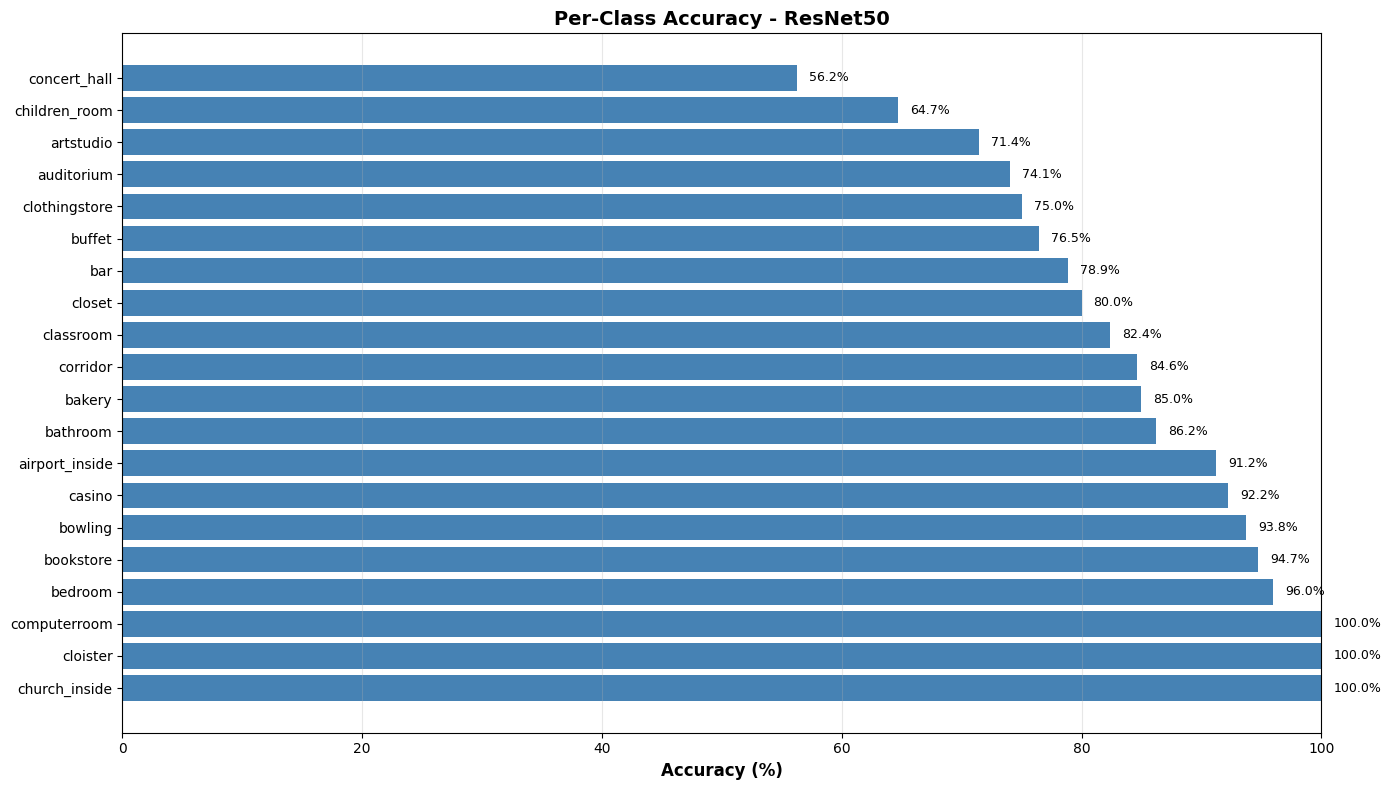


🎉 ResNet50 Training & Evaluation Complete!


In [ ]:
class_names_sorted = [x[0] for x in sorted(class_accuracies, key=lambda x: x[1], reverse=True)]
class_accs_sorted = [x[1] for x in sorted(class_accuracies, key=lambda x: x[1], reverse=True)]

plt.figure(figsize=(14, 8))
bars = plt.barh(class_names_sorted, class_accs_sorted, color='steelblue')
plt.xlabel("Accuracy (%)", fontsize=12, fontweight='bold')
plt.title("Per-Class Accuracy - ResNet50", fontsize=14, fontweight='bold')
plt.xlim(0, 100)
plt.grid(axis='x', alpha=0.3)

# Add values on bars
for i, (bar, acc) in enumerate(zip(bars, class_accs_sorted)):
    plt.text(acc + 1, i, f"{acc:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("🎉 ResNet50 Training & Evaluation Complete!")
print("="*70)
